# Preprocesamiento de una imagen para un único modelo

Importación de librerías

In [1]:
from lbp import lbp
import pandas as pd
import numpy as np
import PIL
from IPython.display import display

Definición de variables globales:

In [2]:
HEIGHT = 608
WIDTH = 576
ORIGINAL_HEIGHT = 584
ORIGINAL_WIDTH = 565
MASK_THRESHOLD = 100
LABEL_THRESHOLD = 30
LBP_RADIUS = 1
LBP_METHOD = 'riu2'

Función para la lectura de imágenes:

In [3]:
def read_img(path):
    """
    Reads a image given the path
    :param path: Image path
    :return: Numpy array containing the information of the image
    """
    img = np.asarray(PIL.Image.open(path).convert('L'))
    return img.copy()

Función para anular los valores de aquellos píxeles que no estén incluidos en la máscara y simplificar así los cálculos del operador LBP:

In [4]:
def filter_by_mask(img, mask_path):
    """
    Cancels the points that correspond to small values of the mask.
    :param img: Numpy array containing the information of the image.
    :param mask_path: str of the path of the mask.
    :return: Numpy array containing the information of the image after the mask has been applied.
    """
    if mask_path is not None:
        mask = read_img(mask_path)
        # img[mask < MASK_THRESHOLD] = np.median(img[mask >= MASK_THRESHOLD])
        img[mask < MASK_THRESHOLD] = 0
    else:
        mask = None
    return img, mask

Adición de píxeles nulos a las imágenes para aumentar sus dimensiones y alcanzar las deseadas:

In [5]:
def rescale_add_borders(img):
    """
    Adds dummy pixels to the given image to rescale the image to the desired size.
    :param img: Numpy array containing the information of the image.
    :return: Numpy array containing the information of the resized image.
    """
    height, width = img.shape
    v_add = np.zeros((HEIGHT - height, width))
    h_add = np.zeros((HEIGHT, WIDTH - width))
    return np.float32(
        np.concatenate((
            np.concatenate((
                v_add,
                img
            ), axis=0),
            h_add
        ), axis=1)
    )

Función que aplica el operador LBP:

In [6]:
def apply_lbp(img, plot=False):
    """
    Returns the LBP values for the given image
    :param img: Numpy array containing the information of the image.
    :param plot: Boolean to determine whether to plot the results
    :return: Numpy array containing the information of the LBP image.
    """
    img = lbp(img, r=LBP_RADIUS, method=LBP_METHOD, plot=plot)
    return img

La siguiente función es la encargada de realizar el reescalado de la imagen:

In [7]:
def rescale(img, dim):
    """
    Resizes the image to the given dimensions.
    PIL.Image.LANCZOS – Calculate the output pixel value using a high-quality Lanczos filter on
    all pixels that may contribute to the output value.
    https://pillow.readthedocs.io/en/stable/handbook/concepts.html
    :param img: original image
    :param dim: (width, height)
    :return: image resized
    """
    im = PIL.Image.fromarray(np.uint8(img))
    if img.shape != dim:
        return np.asarray(im.resize(dim, resample=PIL.Image.LANCZOS))
    else:
        return img

Función que genera una repetición de los píxeles para lograr un mismo número de píxeles de información para cada una de las escalas consideradas

In [8]:
def repeat_pixels(img, n_times):
    img = img[np.repeat(np.arange(img.shape[0]), n_times), :]
    img = img[:, np.repeat(np.arange(img.shape[1]), n_times)]
    return img

Aplicando el conjunto de funciones previas se obtiene una matriz de información con la que posteriormente se obtendrá la base de datos extraída de la imágen procesada.

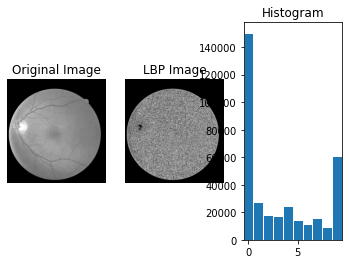

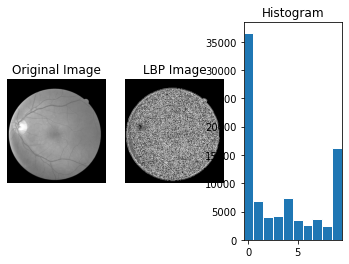

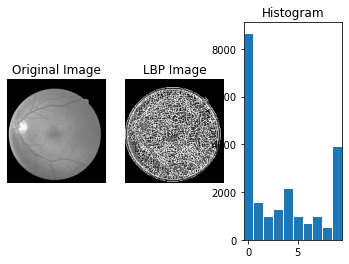

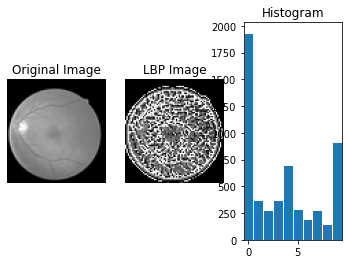

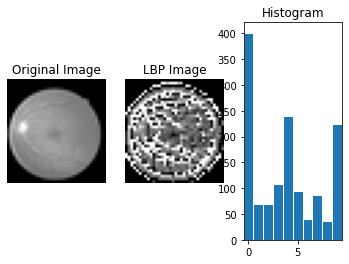

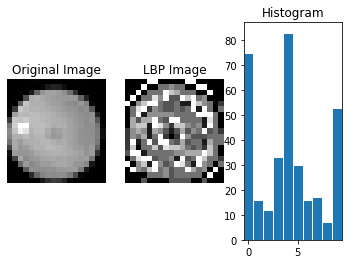

In [9]:
path = 'jupyter-media/21_training.tif'
mask_path = 'jupyter-media/21_training_mask.gif'
plot = True


img = read_img(path)
img, mask = filter_by_mask(img, mask_path)
img = rescale_add_borders(img)
lbp_matrix = np.zeros((HEIGHT * WIDTH, 6))
for i in 2 ** np.arange(6):
    img_resized = rescale(img.copy(), (WIDTH // i, HEIGHT // i))
    img_lbp = apply_lbp(img_resized, plot=plot)
    img_lbp = repeat_pixels(img_lbp, i)
    lbp_matrix[:, int(np.log2(i))] = img_lbp.ravel()

En la matriz de información obtenida, cada fila constituye un píxel de la imagen de mayor resolución y cada columna corresponde a una resolución.

A continuación se eliminan los puntos que no forman parte de la máscara:

In [10]:
def remove_mask_data(arr, mask, remove_borders=False):
    if mask is not None:
        if remove_borders:
            mask_and_borders = rescale_add_borders(mask)
            return (arr[mask_and_borders.ravel() >= MASK_THRESHOLD, :],
                    np.where(mask_and_borders.ravel() >= MASK_THRESHOLD)[0])
        else:
            return (arr[mask.ravel() >= MASK_THRESHOLD, :],
                    np.where(mask.ravel() >= MASK_THRESHOLD)[0])
    else:
        if remove_borders:
            borders = rescale_add_borders(
                np.ones((ORIGINAL_HEIGHT, ORIGINAL_WIDTH)))
            return (arr[borders.ravel() == 1, :],
                    np.where(borders.ravel() >= MASK_THRESHOLD)[0])
        else:
            return arr, np.where(arr.ravel() >= -1)[0]

In [11]:
lbp_matrix, _ = remove_mask_data(lbp_matrix, mask, remove_borders=True)

Se añade la información de las etiquetas correspondientes a cada píxel:

In [12]:
label_path = 'jupyter-media/21_manual1.gif'

In [13]:
def get_label(path):
    img = read_img(path)
    img[img < LABEL_THRESHOLD] = 0
    img[img > LABEL_THRESHOLD] = 1
    return img

In [14]:
def plot_preprocess_with_label(img, label, mask):
    def array_to_mat(arr, mask_mat):
        mat = np.copy(mask_mat)
        mat[mat < MASK_THRESHOLD] = 0
        mat[mat >= MASK_THRESHOLD] = arr.ravel()
        return mat

    if mask is None:
        mask = np.ones((HEIGHT, WIDTH)) * MASK_THRESHOLD
    img = array_to_mat(img, mask)
    img = (img * (255 / np.max(img))).astype(int)
    label = array_to_mat(label, mask)
    img = np.asarray(PIL.Image.fromarray(np.uint8(img)).convert('RGB')).copy()
    img[label == 1] = [255, 0, 0]
    im = PIL.Image.fromarray(np.uint8(img))
    display(im)

In [15]:
if label_path is not None:
    label = get_label(label_path).reshape(-1, 1)
    label, _ = remove_mask_data(label, mask)
    lbp_matrix = np.concatenate((lbp_matrix, label), axis=1)

En la siguiente imagen se muestra una reconstrucción de la imagen LBP a escala original a partir de las posiciones de la máscara y solapando la información de los vasos sanguíneos, confirmando que todo el proceso previo ha sido realizado correctamente:

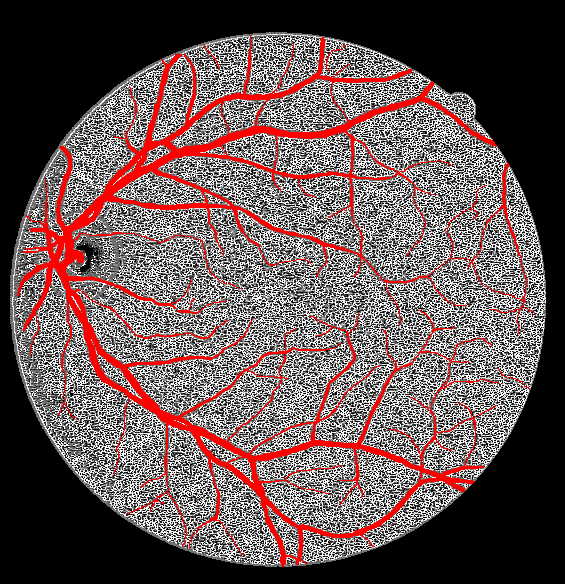

In [16]:
    plot_preprocess_with_label(lbp_matrix[:, 0], lbp_matrix[:, -1], mask)

Lo mismo ocurriría si se toma una imagen de menor resolución:

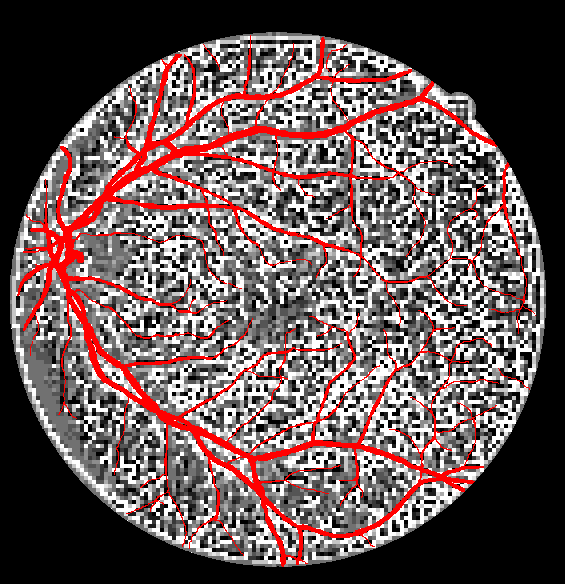

In [17]:
    plot_preprocess_with_label(lbp_matrix[:, 2], lbp_matrix[:, -1], mask)

A continuación se balancea la cantidad de información correspondiente a cada etiqueta, dejando todos los píxeles correspondientes a los vasos sanguíneos y un número igual de píxeles escogidos aleatoriamente entre los restantes. Este proceso solo se realiza en las imágenes seleccionadas a modo de entranamiento.

In [18]:
random_sample = np.random.choice(np.where(lbp_matrix[:, -1] == 0)[0],
                                 size=sum(lbp_matrix[:, -1] == 1),
                                 replace=False)
sample = np.sort(
    np.concatenate((random_sample, np.where(lbp_matrix[:, -1] == 1)[0]))
)
lbp_matrix = lbp_matrix[sample, :]

Finalmente se obtiene un DataFrame con toda la información de las diferentes escalas:

In [19]:
df = pd.DataFrame(lbp_matrix, columns=['1:1', '1:2', '1:4', '1:8', '1:16', '1:32', 'label'], dtype='uint8')

In [20]:
df.head()

,1:1,1:2,1:4,1:8,1:16,1:32,label
0,4,4,4,4,4,5,0
1,5,4,5,4,4,5,0
2,4,5,5,4,4,5,0
3,4,5,5,5,5,5,0
4,3,5,4,4,5,5,0


# Preprocesamiento de una imagen para un modelo en cada escala

El preprocesamiento realizado en el tratamiento de las imágenes de cara a obtener un conjunto de datos para realizar un modelo individual de cada escala se basa en el mismo conjunto de funciones. La función empleada en el procesamiento de cada diferente resolución es la siguiente:

In [1]:
def get_dataset_by_scale(img, label, plot, i):
    img_resized = rescale(img, (WIDTH // i, HEIGHT // i))
    img_lbp = apply_lbp(img_resized, plot=plot)
    img_lbp = repeat_pixels(img_lbp, i)
    if label is not None:
        label_resized = rescale(label.copy(), (WIDTH // i, HEIGHT // i))
        label_resized = repeat_pixels(label_resized, i)
        if plot:
            plot_preprocess_with_label(img_lbp.reshape(-1, 1), label_resized.reshape(-1, 1), None)
        return pd.DataFrame(np.concatenate((img_lbp.reshape(-1, 1), label_resized.reshape(-1, 1)), axis=1))
    else:
        return pd.DataFrame(img_lbp.reshape(-1, 1))

De esta forma, a cada escala se le aplica el operador LBP y se aplica una repetición de los valores proporcionado para cada píxel hasta alcanzar las dimensiones originales.